In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import astropy.units as u

from model_spec import model_spec
import polModel
from draine_dust_torus_model import ddust_torus
from gas_torus_model import gas_torus

## Spectrum, spectrum model and general pol model object

In [2]:
#Load the spectrum. 
spec, spec_model = model_spec()

In [3]:
#Load the general pol modeling objects. 
#import importlib
#importlib.reload(polModel_single_los)
pol_model = polModel.PolModel(spec, spec_model)

In [4]:
#Dictionaries to save the results.
xopt_all  = dict()
mod_p_all = dict() 

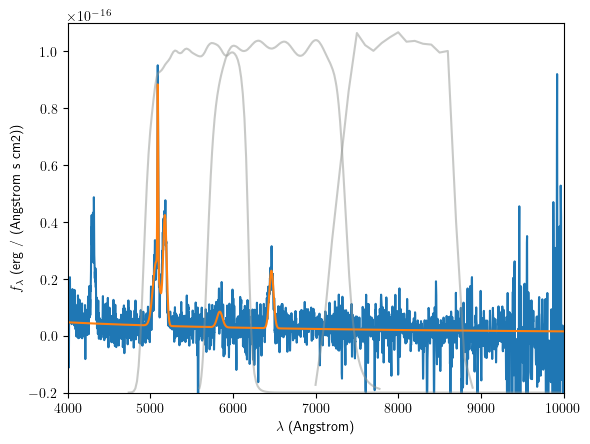

In [5]:
#Plot the spectrum, the best-fit model, and the filter curves.
pol_model.spec_plot()

In [24]:
#General plotting function
def pol_plot(mod_p, spec, show_legend=True):

    data = np.loadtxt("pol_measurements.dat", usecols=[1,2])
    p_measured = data[:,0]
    p_unc = data[:,1]

    wave = np.array([5500., 6500., 8000.]) / spec.zspec

    fig, ax = plt.subplots(1)

    ax.errorbar(wave, p_measured, yerr=p_unc, fmt='ko', label='Measurements')
    for scat_type in mod_p.keys():
        if scat_type[-3:]=="LMC":
            fmt = '^'
        elif scat_type[-3:]=="SMC":
            fmt = 's'
        elif scat_type[-2:]=="MW":
            fmt = 'P'
        else:
            fmt='p'

        ax.plot(wave, mod_p[scat_type], fmt, label=scat_type)

    if show_legend:
        ax.legend(ncol=3)
    ax.set_xlabel('Wavelength (Angstroms)')
    ax.set_ylabel('Polarization fraction')
    plt.show()

## Pure Gas Polarization

#### Same inclination for Continuum and Lines

In [7]:
#Define the scattering object
class Gas_Gas(object):

    def __init__(self):

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2

        #Load the simple gas model. 
        self.gas_obj = gas_torus()

        return

    #In this model, the continuum and emission line polarization fraction is forced to be the same. 
    def pfrac(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0]
        psi = a_pars[1]
        return self.gas_obj.pfrac(([theta],[psi])).flatten()[0] * np.ones(len(lam))
    
    #Continuum polarization fraction    
    def pfrac_A(self, x, lam):
        return self.pfrac(x, lam)

    #Line polarization fraction    
    def pfrac_B(self, x, lam):
        return self.pfrac(x, lam)

In [8]:
scat_obj = Gas_Gas()

##### Force the same polarization angle. 

In [9]:
x0 = np.array([0., 80., 50.])
min_vals = np.array([0., 0., 0.])
max_vals = np.array([0., 90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG0"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p

`xtol` termination condition is satisfied.
[5.88358482e-24 7.47372385e+01 7.46250198e+01]
19.07080476865317


##### Allow for different polarization angles.

In [10]:
x0 = np.array([0., 80., 50.])
min_vals = np.array([0., 0., 0.])
max_vals = np.array([90., 90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG1"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p

`xtol` termination condition is satisfied.
[6.93289888e-03 7.45891733e+01 7.46048544e+01]
19.070805980051844


#### Allow for independent torus opening angles for lines and continuum.

I *believe* that a scatterer very near the accretion disk should be able to be modeled by allowing for different opening angles, which in that model would just simply become for the lines the size of the BLR ring shining into a small scatterer, and for the continuum it would become the covering angle by the scatterer.

In [11]:
#Define the scattering object
class Gas_Gas(object):

    def __init__(self):

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2
        self.npar_b = 1

        #Load the simple gas model. 
        self.gas_obj = gas_torus()

        return

    #In this model, the continuum and emission line polarization fraction is forced to be the same. 
    def pfrac_A(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0]
        psi_A = a_pars[1]
        return self.gas_obj.pfrac(([theta],[psi_A])).flatten()[0] * np.ones(len(lam))
    
    #Emission line polarization.
    def pfrac_B(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0]
        b_pars = x[self.npar_a+1:]
        psi_B = b_pars[0]
        return self.gas_obj.pfrac(([theta],[psi_B])).flatten()[0] * np.ones(len(lam))
    

In [12]:
scat_obj = Gas_Gas()

In [13]:
x0 = np.array([0., 80., 50., 50.])
min_vals = np.array([0., 0., 0., 0.])
max_vals = np.array([90., 90., 90., 90.])
pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
#pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

mname = "GG2"
xopt_all[mname]  = pol_model.xopt
mod_p_all[mname] = pol_model.mod_p

`xtol` termination condition is satisfied.
[44.79287058 61.99206434 72.67327286 50.26017265]
6.4556748097407986e-12


## Pure dust polarization

In [14]:
dust_types = ["SMC", "LMC", "MW"]

#### Require the same polarization for the continuum and the emission lines.

In [15]:
#Define the scattering object
class Dust_Dust(object):

    def __init__(self, dust_type, fw=True, bw=True):

        #Save the input parameters.
        self.dust_type = dust_type
        self.fw = fw
        self.bw = bw

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2

        #Load the simple gas model. 
        self.dust_obj = ddust_torus(self.dust_type, fw=self.fw, bw=self.bw)

        return

    #In this model, the continuum and emission line polarization fraction is forced to be the same. 
    def pfrac(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0] * np.ones(len(lam))
        psi = a_pars[1] * np.ones(len(lam))
        return self.dust_obj.pfrac((lam.to(u.AA).value, theta, psi)).flatten()
    
    #Continuum polarization fraction    
    def pfrac_A(self, x, lam):
        return self.pfrac(x, lam)

    #Line polarization fraction    
    def pfrac_B(self, x, lam):
        return self.pfrac(x, lam)

##### Force the same polarization angle. 

In [16]:
for dust_type in dust_types:
    print(dust_type)

    x0 = np.array([0., 80., 45.])
    min_vals = np.array([0., 0., 0.])
    max_vals = np.array([0., 90., 90.])

    #Consider forward+backward, forward and backward only options.
    for i in range(3):
        suffix = ""
        if i==0:
            fw=True
            bw=True
            suffix="FWBW"
        elif i==1:
            fw=True
            bw=False
            suffix="FW"
        else:
            fw=False
            bw=True
            suffix="BW"
        print(suffix)
        scat_obj = Dust_Dust(dust_type, fw=fw, bw=bw)
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DD0_"+suffix+"_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p

    print()

SMC
FWBW
`xtol` termination condition is satisfied.
[-1.81133482e-23  6.53192888e+01  4.80692306e+01]
429.53328182875714
FW
`xtol` termination condition is satisfied.
[-1.74144804e-24  5.83070381e+01  3.69667215e+01]
396.5042535903607
BW
`xtol` termination condition is satisfied.
[2.24535977e-24 6.10000000e+01 6.12004123e+01]
419.28307582689496

LMC
FWBW
`xtol` termination condition is satisfied.
[-1.61782198e-22  6.50856932e+01  4.82268497e+01]
676.9685774329769
FW
`xtol` termination condition is satisfied.
[-1.33803117e-25  4.34999999e+01  1.94262640e+01]
572.9473660533199
BW
`xtol` termination condition is satisfied.
[-3.74962305e-24  7.09999996e+01  6.38858736e+01]
673.0054219984557

MW
FWBW
`gtol` termination condition is satisfied.
[-2.40843049e-25  3.74757780e+01  7.23506780e-07]
272.3180650145765
FW
`xtol` termination condition is satisfied.
[8.67999600e-26 3.86602775e+01 7.97911748e+00]
185.22081931730327
BW
`xtol` termination condition is satisfied.
[-7.89927743e-20  9.000000

##### Allow for different polarization angles. 

In [17]:
for dust_type in dust_types:
    print(dust_type)

    x0 = np.array([0., 80., 45.])
    min_vals = np.array([0., 0., 0.])
    max_vals = np.array([90., 90., 90.])

    #Consider forward+backward, forward and backward only options.
    for i in range(3):
        suffix = ""
        if i==0:
            fw=True
            bw=True
            suffix="FWBW"
        elif i==1:
            fw=True
            bw=False
            suffix="FW"
        else:
            fw=False
            bw=True
            suffix="BW"
        print(suffix)
        scat_obj = Dust_Dust(dust_type, fw=fw, bw=bw)
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DD1_"+suffix+"_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p

    print()

SMC
FWBW
`gtol` termination condition is satisfied.
[76.16483765 89.99997312 30.70230977]
0.2711662164069519
FW
`gtol` termination condition is satisfied.
[75.33221554 84.53214121 28.97850152]
5.605612639372454e-11
BW
`xtol` termination condition is satisfied.
[76.14104824 89.99999992 30.69416594]
0.2553148729417739

LMC
FWBW
`xtol` termination condition is satisfied.
[86.91033582 89.14232655  0.99999999]
67.30073187874056
FW
`xtol` termination condition is satisfied.
[8.39604179e+01 8.14122115e+01 3.37722218e-07]
31.436335978580928
BW
`gtol` termination condition is satisfied.
[8.72255416e+01 9.00000000e+01 2.79295252e-07]
68.237472100887

MW
FWBW
`xtol` termination condition is satisfied.
[7.56330964e+01 7.05564791e+01 6.50022949e-05]
0.35713837603865695
FW
`gtol` termination condition is satisfied.
[73.764782   83.3480326  25.07184405]
1.1010929093065205e-11
BW
`gtol` termination condition is satisfied.
[75.92313343 89.99999982 22.86138475]
0.6497011672668154



## Gas and Dust polarization 

##### Require the same inclination

In [18]:
#Define the scattering object
class Gas_Dust(object):

    def __init__(self, dust_type, fw=True, bw=True):

        #Save the input parameters.
        self.dust_type = dust_type
        self.fw = fw
        self.bw = bw

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2
        self.npar_b = 1

        #Load the simple gas model. 
        self.dust_obj = ddust_torus(self.dust_type, fw=self.fw, bw=self.bw)
        self.gas_obj = gas_torus()

        return

    #Continuum polarization
    def pfrac_A(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0] * np.ones(len(lam))
        psi_A = a_pars[1] * np.ones(len(lam))
        return self.dust_obj.pfrac((lam.to(u.AA).value, theta, psi_A)).flatten()
    
    #Lines polarization.
    def pfrac_B(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta = a_pars[0] * np.ones(len(lam))
        b_pars = x[self.npar_a+1:]
        psi_B = b_pars[0] * np.ones(len(lam))
        return self.dust_obj.pfrac((lam.to(u.AA).value, theta, psi_B)).flatten()
    

In [19]:
for dust_type in dust_types:
    print(dust_type)

    x0 = np.array([0., 80., 45., 45.])
    min_vals = np.array([0., 0., 0., 0.])
    max_vals = np.array([90., 90., 90., 90.])

    #Consider forward+backward, forward and backward only options.
    for i in range(3):
        suffix = ""
        if i==0:
            fw=True
            bw=True
            suffix="FWBW"
        elif i==1:
            fw=True
            bw=False
            suffix="FW"
        else:
            fw=False
            bw=True
            suffix="BW"
        print(suffix)
        scat_obj = Gas_Dust(dust_type, fw=fw, bw=bw)
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DG1_"+suffix+"_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p

    print()

SMC
FWBW
`xtol` termination condition is satisfied.
[ 4.98985579 73.21384557 42.1230317  89.87272349]
178.73721492960019
FW
`xtol` termination condition is satisfied.
[ 3.64583854 61.89448761 27.07008694 79.69255542]
134.80470058172315
BW
`xtol` termination condition is satisfied.
[ 5.36263174 89.99977827 48.1640271  89.76604808]
183.51316158879058

LMC
FWBW
`xtol` termination condition is satisfied.
[ 3.49976078 72.77825591 41.62643615 89.87873824]
439.35945017241835
FW
`xtol` termination condition is satisfied.
[ 4.8022841  48.7250554   0.21406503 74.55067556]
255.99394809937138
BW
`xtol` termination condition is satisfied.
[ 2.57679931 89.99990642 48.10575439 89.7017229 ]
448.0735195860476

MW
FWBW
`xtol` termination condition is satisfied.
[6.35126214e+00 4.85667200e+01 5.10987147e-03 8.99539804e+01]
98.889365332542
FW
`xtol` termination condition is satisfied.
[ 7.16853701 47.6910422   0.67751249 72.05157959]
19.254928556194848
BW
`xtol` termination condition is satisfied.
[ 3.390

##### Allow for different inclinations

In [20]:
#Define the scattering object
class Gas_Dust(object):

    def __init__(self, dust_type, fw=True, bw=True):

        #Save the input parameters.
        self.dust_type = dust_type
        self.fw = fw
        self.bw = bw

        #Set the number of parameters for the continuum (a) and the lines (b). The order in x is always: delta_chi, a model parameters, b model parameters (if any).
        self.npar_a = 2
        self.npar_b = 2

        #Load the simple gas model. 
        self.dust_obj = ddust_torus(self.dust_type, fw=self.fw, bw=self.bw)
        self.gas_obj = gas_torus()

        return

    #Continuum polarization
    def pfrac_A(self, x, lam):
        a_pars = x[1:self.npar_a+1]
        theta_A = a_pars[0] * np.ones(len(lam))
        psi_A   = a_pars[1] * np.ones(len(lam))
        return self.dust_obj.pfrac((lam.to(u.AA).value, theta_A, psi_A)).flatten()
    
    #Lines polarization.
    def pfrac_B(self, x, lam):
        b_pars = x[self.npar_a+1:]
        theta_B = b_pars[0] * np.ones(len(lam))
        psi_B   = b_pars[1] * np.ones(len(lam))
        return self.dust_obj.pfrac((lam.to(u.AA).value, theta_B, psi_B)).flatten()
    

In [21]:
for dust_type in dust_types:
    print(dust_type)

    x0 = np.array([0., 80., 45., 80., 45.])
    min_vals = np.array([0., 0., 0., 0., 0.])
    max_vals = np.array([90., 90., 90., 90., 90.])

    #Consider forward+backward, forward and backward only options.
    for i in range(3):
        suffix = ""
        if i==0:
            fw=True
            bw=True
            suffix="FWBW"
        elif i==1:
            fw=True
            bw=False
            suffix="FW"
        else:
            fw=False
            bw=True
            suffix="BW"
        print(suffix)
        scat_obj = Gas_Dust(dust_type, fw=fw, bw=bw)
        pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='trust-constr')
        #pol_model.fit_pol(scat_obj, x0, min_vals, max_vals, method='BFGS')

        mname = "DG2_"+suffix+"_"+dust_type
        if mname not in xopt_all or pol_model.xopt.fun < xopt_all[mname].fun:
            xopt_all[mname]  = pol_model.xopt
            mod_p_all[mname] = pol_model.mod_p

    print()

SMC
FWBW
`xtol` termination condition is satisfied.
[ 3.21402591 73.36444141 42.23768929 55.30982946 89.924055  ]
178.73521942242354
FW
`xtol` termination condition is satisfied.
[ 3.03783139 60.87160638 25.69671347 42.68812402 74.93808079]
134.57354912583367
BW
`xtol` termination condition is satisfied.
[ 4.06414793 89.96528249 48.17245522 89.62378436 89.91873923]
183.601414172435

LMC
FWBW
`xtol` termination condition is satisfied.
[ 4.74073215 72.84564447 41.67679882 53.09811956 89.93722222]
439.3587950399473
FW
`xtol` termination condition is satisfied.
[ 8.29593982 48.73088925  0.36497486 45.78462152 73.85424901]
256.02218721782606
BW
`xtol` termination condition is satisfied.
[ 4.49766941 89.98845392 48.1149184  89.82737985 89.78522928]
448.15621240124784

MW
FWBW
`xtol` termination condition is satisfied.
[6.32431184e+00 4.85665056e+01 4.91008136e-03 5.07111956e+01
 8.99453692e+01]
98.88960407637515
FW
`xtol` termination condition is satisfied.
[2.26199051e+00 4.76772345e+01 1.4

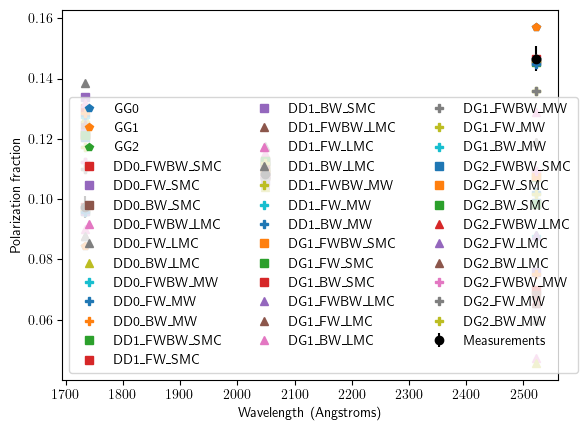

In [25]:
pol_plot(mod_p_all, spec)

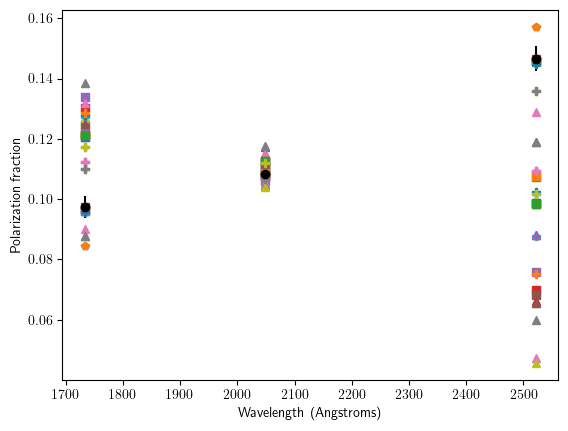

In [26]:
pol_plot(mod_p_all, spec, show_legend=False)

In [23]:
#Rank solutions from best to worse. 
model_names = list(xopt_all.keys())
fun_all = np.zeros(len(model_names))
for i, mname in enumerate(model_names):
    fun_all[i] = xopt_all[mname].fun
k = np.argsort(fun_all)
for kk in k:
    mname = model_names[kk]
    print(mname, xopt_all[mname].fun, xopt_all[mname].x)

GG2 6.4556748097407986e-12 [44.79287058 61.99206434 72.67327286 50.26017265]
DD1_FW_MW 1.1010929093065205e-11 [73.764782   83.3480326  25.07184405]
DD1_FW_SMC 5.605612639372454e-11 [75.33221554 84.53214121 28.97850152]
DD1_BW_SMC 0.2553148729417739 [76.14104824 89.99999992 30.69416594]
DD1_FWBW_SMC 0.2711662164069519 [76.16483765 89.99997312 30.70230977]
DD1_FWBW_MW 0.35713837603865695 [7.56330964e+01 7.05564791e+01 6.50022949e-05]
DD1_BW_MW 0.6497011672668154 [75.92313343 89.99999982 22.86138475]
GG0 19.07080476865317 [5.88358482e-24 7.47372385e+01 7.46250198e+01]
GG1 19.070805980051844 [6.93289888e-03 7.45891733e+01 7.46048544e+01]
DG2_FW_MW 19.233984049097977 [2.26199051e+00 4.76772345e+01 1.44716403e-03 4.64275331e+01
 7.16793386e+01]
DG1_FW_MW 19.254928556194848 [ 7.16853701 47.6910422   0.67751249 72.05157959]
DD1_FW_LMC 31.436335978580928 [8.39604179e+01 8.14122115e+01 3.37722218e-07]
DD1_FWBW_LMC 67.30073187874056 [86.91033582 89.14232655  0.99999999]
DD1_BW_LMC 68.237472100887